In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian, convolve2d, correlate
from scipy.fft import fft2, ifft2, fftshift
from skimage import io, img_as_ubyte, util, color
from skimage.metrics import peak_signal_noise_ratio

plt.style.use('dark_background')

# Declaration des filtres

In [2]:
# Scipy's version
def wiener(im, mysize=None, noise=None):
    """
    Perform a Wiener filter on an N-dimensional array.

    Apply a Wiener filter to the N-dimensional array `im`.

    Parameters
    ----------
    im : ndarray
        An N-dimensional array.
    mysize : int or array_like, optional
        A scalar or an N-length list giving the size of the Wiener filter
        window in each dimension.  Elements of mysize should be odd.
        If mysize is a scalar, then this scalar is used as the size
        in each dimension.
    noise : float, optional
        The noise-power to use. If None, then noise is estimated as the
        average of the local variance of the input.

    Returns
    -------
    out : ndarray
        Wiener filtered result with the same shape as `im`.

    Notes
    -----
    This implementation is similar to wiener2 in Matlab/Octave.
    For more details see [1]_
    """
    
    im = np.asarray(im)
    if mysize is None:
        mysize = [3] * im.ndim
    mysize = np.asarray(mysize)
    if mysize.shape == ():
        mysize = np.repeat(mysize.item(), im.ndim)

    # Estimate the local mean
    lMean = correlate(im, np.ones(mysize), 'same') / np.prod(mysize, axis=0)

    # Estimate the local variance
    lVar = (correlate(im ** 2, np.ones(mysize), 'same') /
            np.prod(mysize, axis=0) - lMean ** 2)

    # Estimate the noise power if needed.
    if noise is None:
        noise = np.mean(np.ravel(lVar), axis=0)

    res = (im - lMean)
    res *= (1 - noise / lVar)
    res += lMean
    out = np.where(lVar < noise, lMean, res)

    return out

In [3]:
# Le-Anh Tran's version
def add_gaussian_noise(img, sigma):
    gauss = np.random.normal(0, sigma, np.shape(img))
    gauss = gauss / np.max(np.abs(gauss))
    noisy_img = img + gauss
    noisy_img = np.clip(noisy_img, 0, 1)
    noisy_img[noisy_img < 0] = 0
    noisy_img[noisy_img > 255] = 255
    return noisy_img

def blur(img, kernel_size = 3):
    dummy = np.copy(img)
    h = np.eye(kernel_size) / kernel_size
    dummy = convolve2d(dummy, h, mode = 'same')
    return dummy

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h

def tran_wiener(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

In [4]:
# Based on the algorithm of Matlab
def our_wiener(image, neighborhood_size=(3, 3), noise=None):
    image_height, image_width = image.shape
    
    # Calculer le noyau de flou
    kernel = np.ones(neighborhood_size) / np.prod(neighborhood_size)

    # Flou de l'image
    blurred_image = convolve2d(image.astype(np.float64), kernel, mode='same')

    # Calculer la variance du bruit s'il n'est pas donné
    if noise is None:
        noise = np.mean(np.var(image))

    # Initialiser l'image filtrée
    filtered_image = np.zeros_like(image, dtype=np.float64)

    # Parcourir chaque pixel de l'image
    for i in range(image_height):
        for j in range(image_width):
            # Calculer les limites du voisinage local autour du pixel
            row_start = max(0, i - neighborhood_size[0] // 2)
            row_end = min(image_height, i + neighborhood_size[0] // 2 + 1)
            col_start = max(0, j - neighborhood_size[1] // 2)
            col_end = min(image_width, j + neighborhood_size[1] // 2 + 1)

            # Extraire le voisinage local flou
            local_blurred = blurred_image[row_start:row_end, col_start:col_end]

            # Estimer la moyenne locale et la variance locale
            local_mean = local_blurred[i - row_start, j - col_start]
            local_variance = np.mean(np.square(local_blurred - local_mean))

            # Appliquer le filtre de Wiener pixel par pixel
            filtered_pixel = local_mean + (local_variance - noise) / \
                             np.maximum(local_variance, noise) * \
                             (image[i, j] - local_mean)

            filtered_pixel = np.clip(filtered_pixel, 0, 1)
            # Assigner la valeur filtrée au pixel correspondant dans l'image filtrée
            filtered_image[i, j] = filtered_pixel

    return filtered_image.astype(image.dtype)

TODO : Add skimage wiener implementation for Vincent

# Chargement et application des filtres

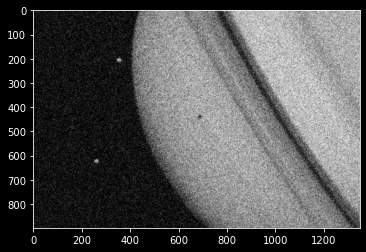

In [5]:
# Load greyscale image
original_image = io.imread('data/saturn.png')[:, :, :3]
original_image = color.rgb2gray(original_image)

# Blur it and add noise
sigma = 1
#blurred_img = blur(original_image, kernel_size=1)
#noisy_image = add_gaussian_noise(blurred_img, sigma=sigma)
#noisy_image = util.random_noise(original_image, mode='gaussian', var=0.3, mean=-0.3)
noisy_image = original_image

plt.imshow(noisy_image, cmap='gray')

In [6]:
scipy_image = wiener(noisy_image, mysize=3, noise=1.0)
tran_image = tran_wiener(noisy_image, gaussian_kernel(5), K=10)
our_image = our_wiener(noisy_image)

/tmp/ipykernel_11882/3665322626.py:51: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
/tmp/ipykernel_11882/3665322626.py:51: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


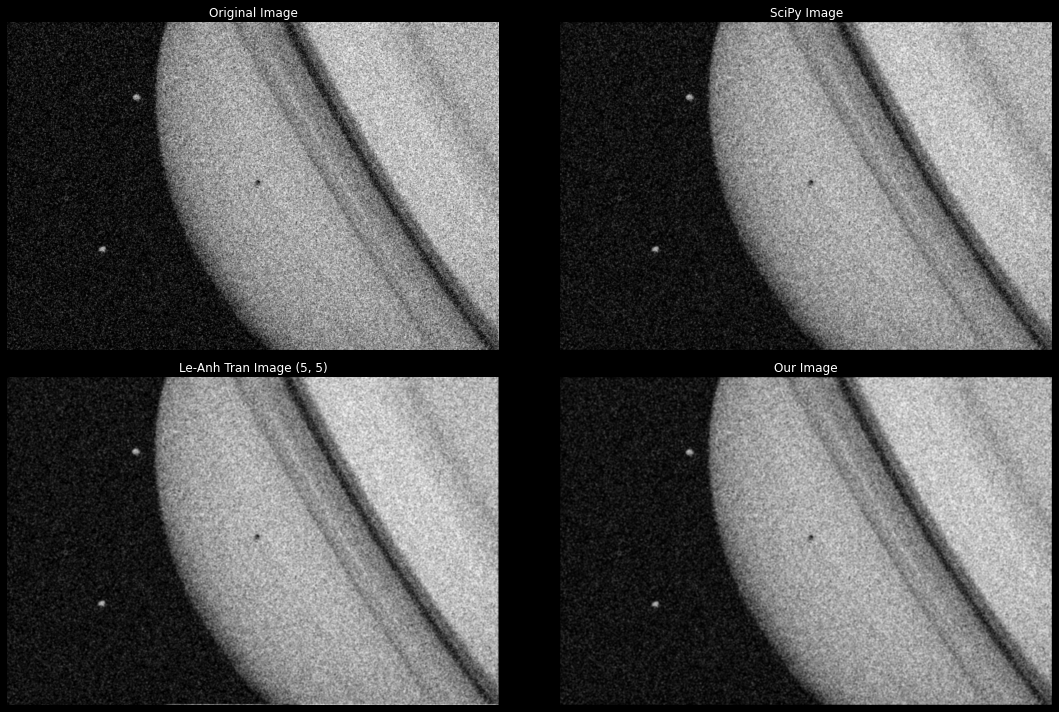

In [12]:
# Afficher les images côte à côte
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Afficher l'image originale
axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title('Original Image')

# Afficher le filtre avec neighborhood_size = (1, 1)
axes[0, 1].imshow(scipy_image, cmap='gray')
axes[0, 1].set_title('SciPy Image')

# Afficher le filtre avec neighborhood_size = (3, 3)
axes[1, 0].imshow(tran_image, cmap='gray')
axes[1, 0].set_title('Le-Anh Tran Image (5, 5)')

# Afficher le filtre avec neighborhood_size = (5, 5)
axes[1, 1].imshow(our_image, cmap='gray')
axes[1, 1].set_title('Our Image')

# Supprimer les axes et ajuster les espacements
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()

# Afficher le plot
plt.show()

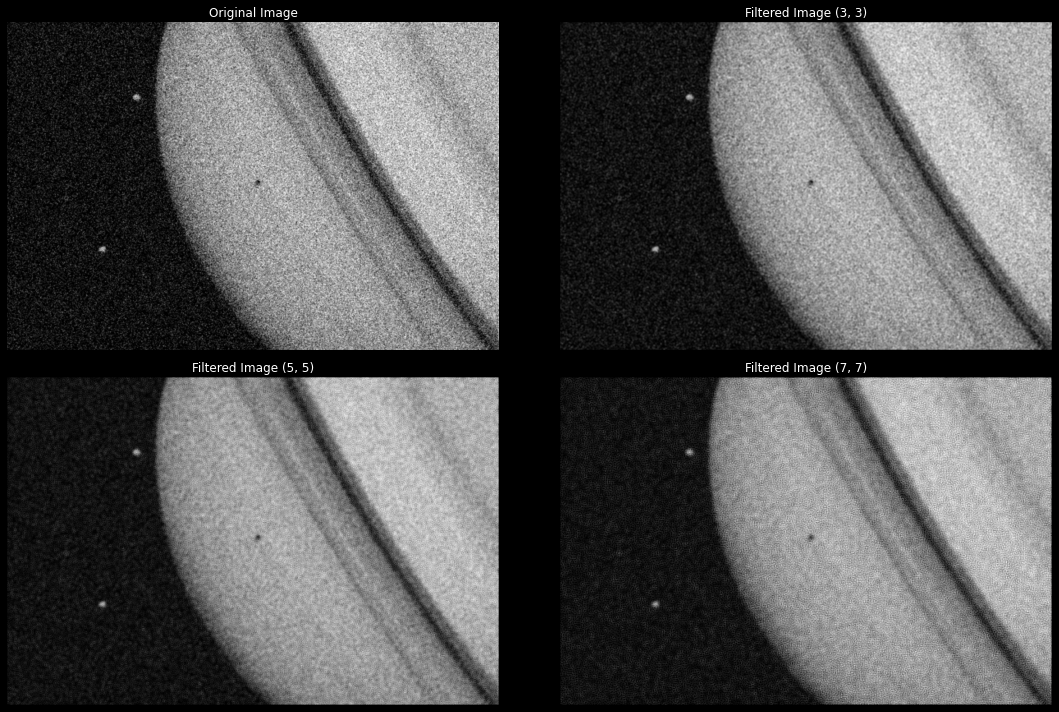

In [61]:
# Appliquer le filtre de Wiener avec différentes tailles de voisinage
filtered_image_3 = our_wiener(original_image, neighborhood_size=(3, 3))
filtered_image_5 = our_wiener(original_image, neighborhood_size=(5, 5))
filtered_image_7 = our_wiener(original_image, neighborhood_size=(7, 7))

# Afficher les images côte à côte
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Afficher l'image originale
axes[0, 0].imshow(original_image, cmap='gray')
axes[0, 0].set_title('Original Image')

# Afficher le filtre avec neighborhood_size = (1, 1)
axes[0, 1].imshow(filtered_image_3, cmap='gray')
axes[0, 1].set_title('Filtered Image (3, 3)')

# Afficher le filtre avec neighborhood_size = (3, 3)
axes[1, 0].imshow(filtered_image_5, cmap='gray')
axes[1, 0].set_title('Filtered Image (5, 5)')

# Afficher le filtre avec neighborhood_size = (5, 5)
axes[1, 1].imshow(filtered_image_7, cmap='gray')
axes[1, 1].set_title('Filtered Image (7, 7)')

# Supprimer les axes et ajuster les espacements
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()

# Afficher le plot
plt.show()

In [10]:
original_image = img_as_ubyte(original_image)
scipy_image = img_as_ubyte(scipy_image)
tran_image = img_as_ubyte(tran_image)
our_image = img_as_ubyte(our_image)

psnr_value_scipy = peak_signal_noise_ratio(original_image, scipy_image)
psnr_value_tran = peak_signal_noise_ratio(original_image, tran_image)
psnr_value_our = peak_signal_noise_ratio(original_image, our_image)

print("PSNR from SciPy:", psnr_value_scipy)
print("PSNR from us:", psnr_value_our)
print("PSNR from Le-Anh Tran:", psnr_value_tran)

PSNR from SciPy: 29.17869202177266
PSNR from us: 23.399965865800002
PSNR from Le-Anh Tran: 7.004233278345218


# Pistes d'ameliorations
- Implement the wien.m in Python
- Pipeline the algorithms

# Other versions we considered

In [ ]:
# Andy Doran's code reimplemented in Python
def andy_doran_wiener(image, No):
    xdim = image.shape[0]
    
    # Create LSI degradation model
    hi = 3.5 ** (-2)
    h = np.zeros((xdim, xdim))
    xl = 4
    xh = xdim - xl + 2
    h[0:xl, 0:xl] = hi
    h[xh:xdim, 0:xl] = hi
    h[0:xl, xh:xdim] = hi
    h[xh:xdim, xh:xdim] = hi
    
    # Create Gaussian noise
    noise = np.sqrt(No) * np.random.randn(xdim, xdim)
    
    # Apply LSI filter and add noise
    dpict = np.fft.ifft2(np.fft.fft2(image) * np.fft.fft2(h, (xdim, xdim)) + np.fft.fft2(noise))
    
    # Calculate MSE of degraded image
    error = dpict - image
    sqerr = np.sum(np.square(error))
    DMSE = sqerr / (xdim ** 2)
    
    # Calculate power spectral density of input image
    PICT = np.fft.fft2(image)
    Suu = np.abs(PICT) ** 2
    
    # Calculate power spectral density of the AGN
    NOISE = np.fft.fft2(noise)
    Snn = np.abs(NOISE) ** 2
    
    # Calculate Fourier Transform of LSI Filter
    H = np.fft.fft2(h, (xdim, xdim))
    H2 = np.abs(H) ** 2
    
    # Calculate thresholded 1/H
    HINV = np.copy(H)
    index = np.abs(H) < 0.2
    hzeros = np.sum(index)
    HINV[index] = 0
    
    # Calculate Wiener Filter
    G = HINV * (H2 * Suu) / ((H2 * Suu) + Snn)
    
    # Restore Image
    DPICT = np.fft.fft2(dpict)
    RPICT = DPICT * G
    rpict = np.fft.ifft2(RPICT)
    
    # Calculate MSE of restored image
    error = np.abs(rpict) - image
    sqerr = np.sum(np.square(error))
    RMSE = sqerr / (xdim ** 2)
    
    # Calculate MSE of restored image through Wiener filtering
    wpict = scipy.signal.wiener(dpict, mysize=(16, 16))
    error = np.abs(wpict) - image
    sqerr = np.sum(np.square(error))
    WMSE = sqerr / (xdim ** 2)
    
    return rpict, RMSE, WMSE

In [ ]:
# Eric Tramel's version 
def eric_tramel_wiener(g, nhood=(3, 3), noise=None):
    classin = g.dtype
    classChanged = False
    if g.dtype != np.float64:
        classChanged = True
        g = g.astype(np.float64)

    # Estimate the local mean of f.
    localMean = np.mean(g, axis=(0, 1))

    # Estimate of the local variance of f.
    localVar = np.var(g, axis=(0, 1))

    # Estimate the noise power if necessary.
    if noise is None:
        noise = np.mean(localVar)

    # Compute result
    f = g - localMean
    g = localVar - noise
    g = np.maximum(g, 0)
    localVar = np.maximum(localVar, noise)
    f = f / localVar
    f = f * g
    f = f + localMean

    if classChanged:
        f = f.astype(classin)

    return f